# Linear Regression - BTC Daily Dataset

In [42]:
! pip install mplfinance

   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   ---------------- ----------------------- 30.7/75.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 75.0/75.0 kB 1.0 MB/s eta 0:00:00


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn . metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

## Load Dataset

In [32]:
df = pd.read_csv("data/BTC-Daily.csv")
df.head()

unix                 date   symbol      open      high       low  \
0  1646092800  2022-03-01 00:00:00  BTC/USD  43221.71  43626.49  43185.48   
1  1646006400  2022-02-28 00:00:00  BTC/USD  37717.10  44256.08  37468.99   
2  1645920000  2022-02-27 00:00:00  BTC/USD  39146.66  39886.92  37015.74   
3  1645833600  2022-02-26 00:00:00  BTC/USD  39242.64  40330.99  38600.00   
4  1645747200  2022-02-25 00:00:00  BTC/USD  38360.93  39727.97  38027.61   

      close   Volume BTC    Volume USD  
0  43185.48    49.006289  2.116360e+06  
1  43178.98  3160.618070  1.364723e+08  
2  37712.68  1701.817043  6.418008e+07  
3  39146.66   912.724087  3.573010e+07  
4  39231.64  2202.851827  8.642149e+07

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


In [34]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unix        2651 non-null   int64  
 1   date        2651 non-null   object 
 2   symbol      2651 non-null   object 
 3   open        2651 non-null   float64
 4   high        2651 non-null   float64
 5   low         2651 non-null   float64
 6   close       2651 non-null   float64
 7   Volume BTC  2651 non-null   float64
 8   Volume USD  2651 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 186.5+ KB


In [35]:
df["date"] = pd.to_datetime(df["date"])
date_range = str(df["date"].dt.date.min())  + " to " + str(df["date"].dt.date.max())
date_range

'2014-11-28 to 2022-03-01'

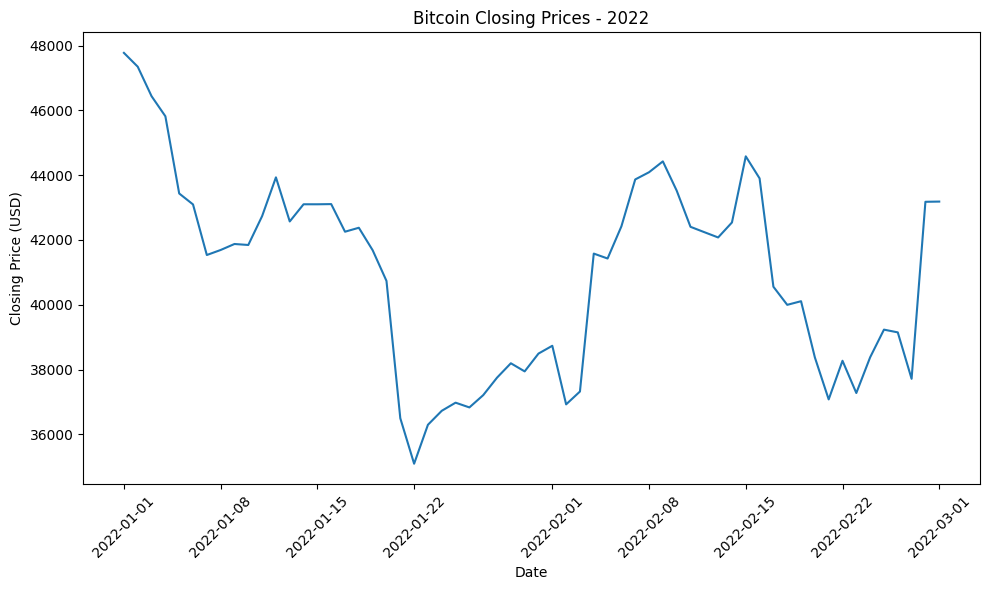

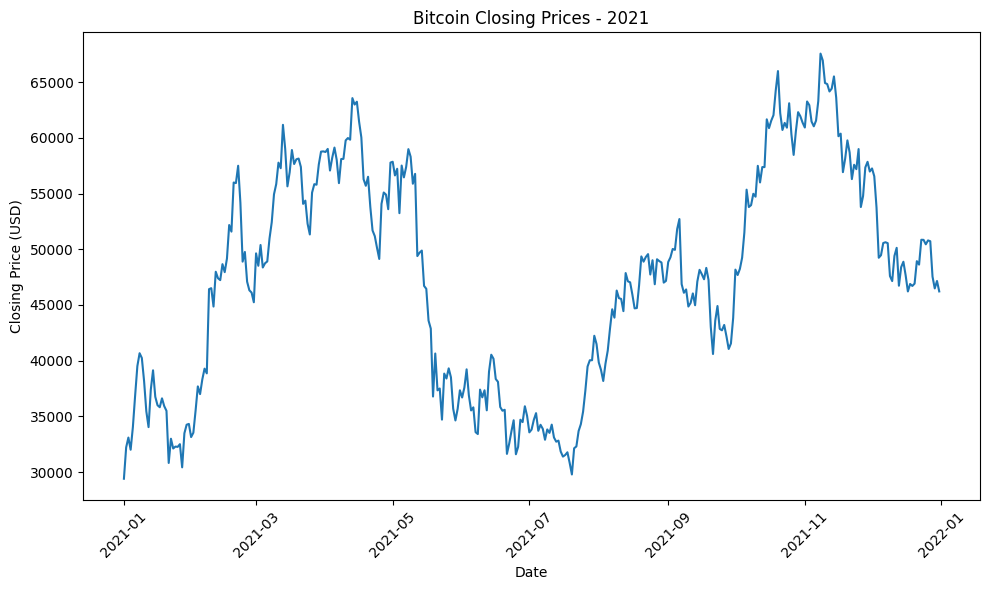

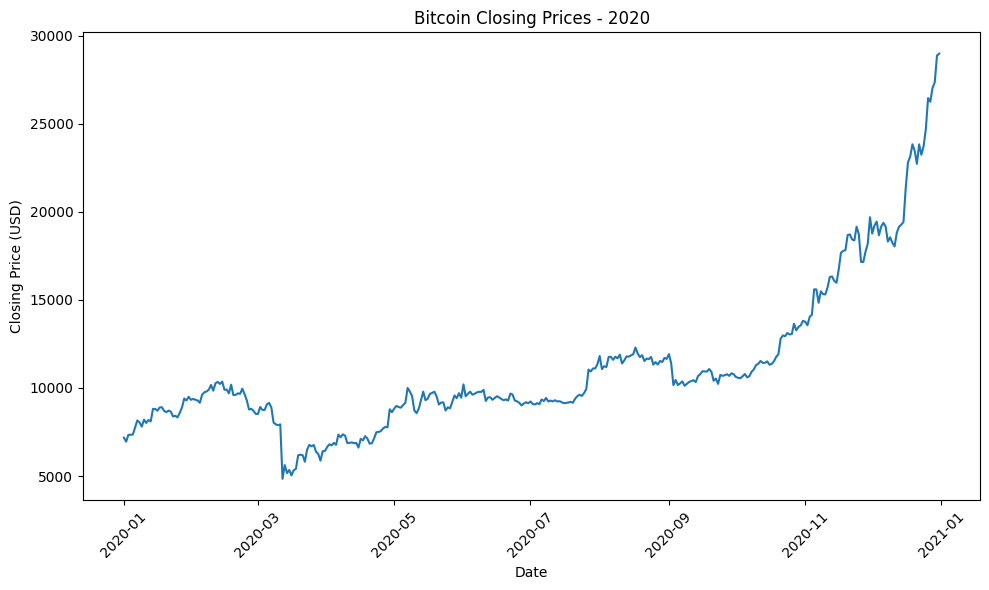

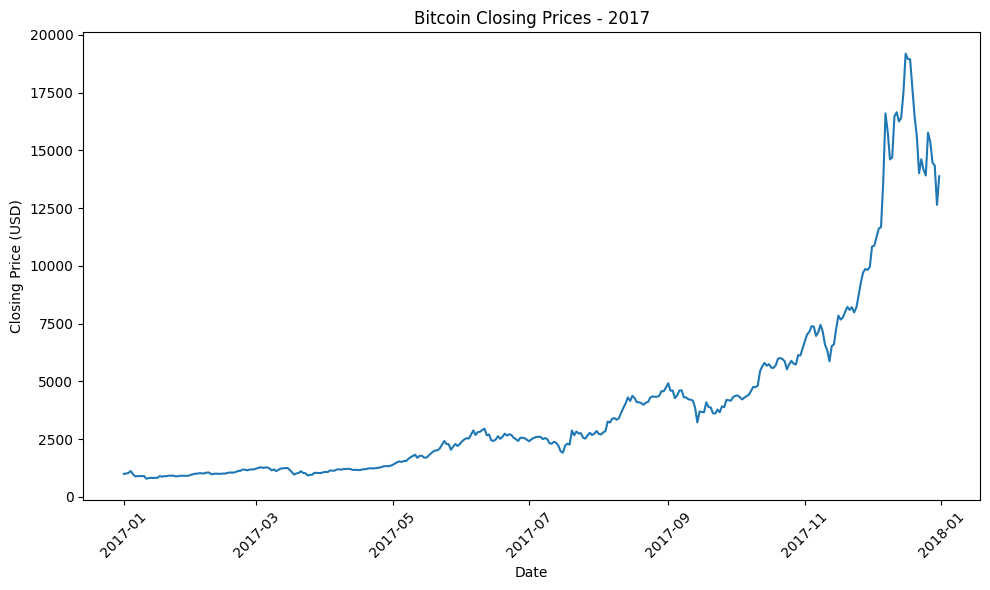

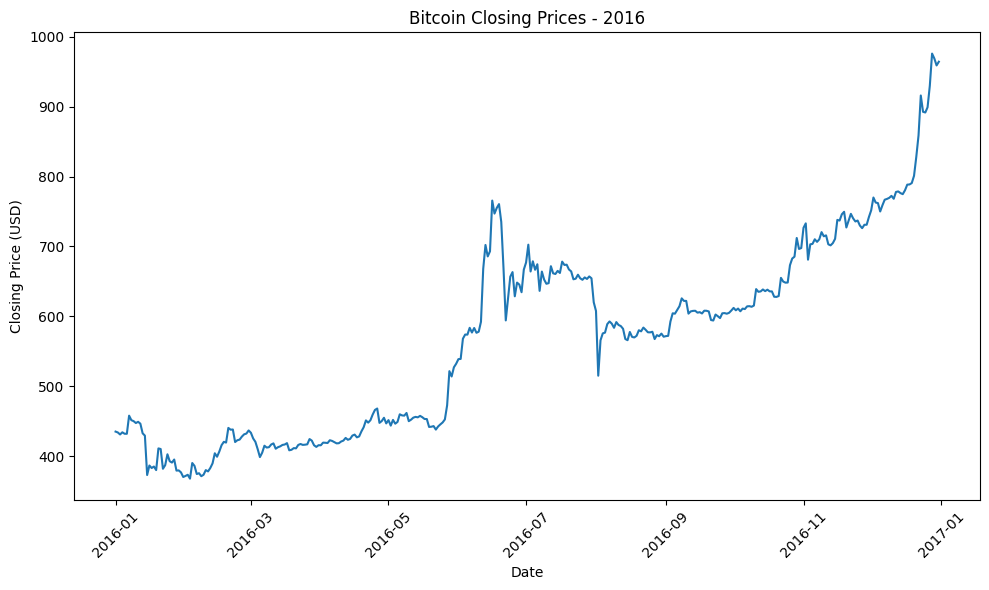

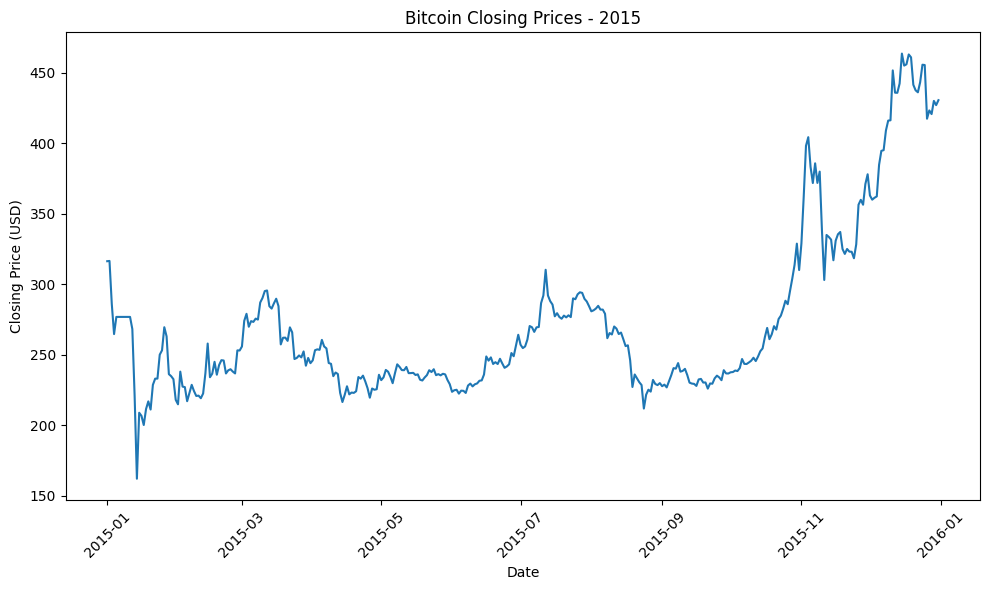

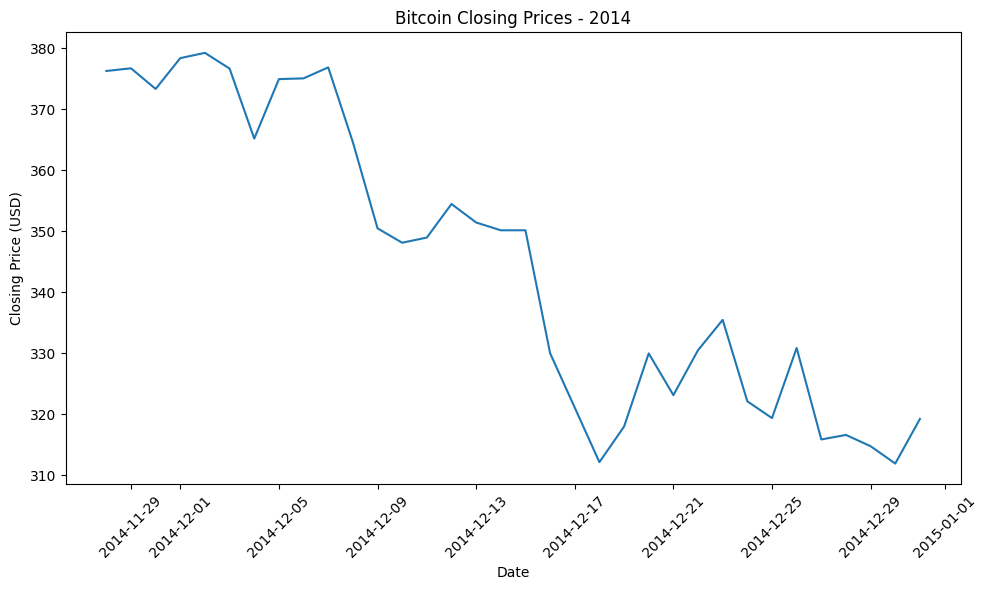

In [41]:
unique_years = df["date"].dt.year.unique()

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

for year in unique_years:
    year_data = df[df['year'] == year]
    year_month_day = year_data[['year', 'month', 'day']]
    merged_data = pd.merge(year_month_day, df, on=["year", "month", "day"], how="left")
    
    plt.figure(figsize=(10 , 6) )
    plt.plot(merged_data["date"], merged_data["close"])
    plt.title(f"Bitcoin Closing Prices - { year }")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (USD)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

C:\Users\LinhLinh\AppData\Local\Temp\ipykernel_22820\2427622337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["date"] = df_filtered["date"].map(mdates.date2num)


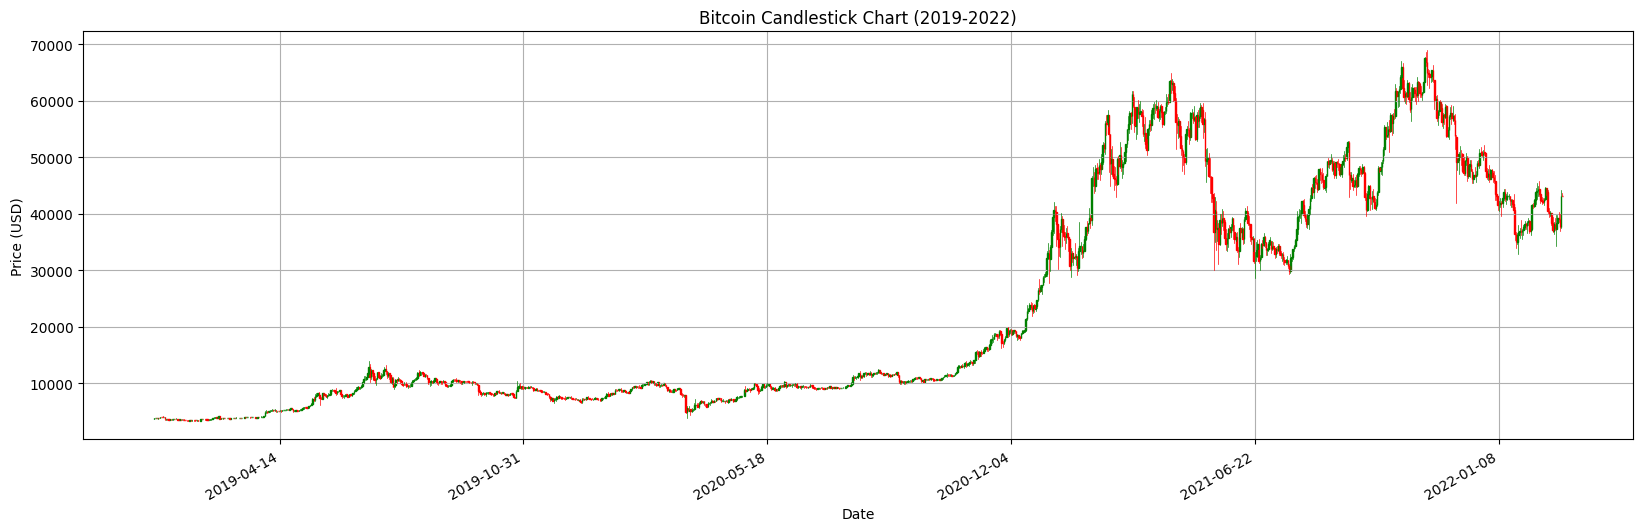

In [46]:
df_filtered = df[(df["date"] >= "2019-01-01") & (df["date"] <= "2022-12-31")]

df_filtered["date"] = df_filtered["date"].map(mdates.date2num)

fig, ax = plt.subplots(figsize=(20, 6))
candlestick_ohlc(ax, df_filtered[["date", "open", "high", "low", "close"]].values, width=0.6, colorup="g", colordown="r")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
fig.autofmt_xdate()

plt.title("Bitcoin Candlestick Chart (2019-2022)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)

plt.show()

## Linear Regression Vectorized

In [68]:
def predict(X, w, b):
    return X.dot(w) + b

def gradient(y_hat, y, x):
    loss = y_hat - y
    dw = x.T.dot(loss) / len(y)
    db = np.sum(loss) / len(y)
    cost = np.sum(loss**2) / (2 * len(y))
    return (dw, db, cost)

def update_weight(w, b, lr, dw, db):
    w_new = w - dw * lr
    b_new = b - db * lr
    return (w_new, b_new)

In [85]:
X = df[['open', 'high', 'low']].values
y = df['close'].values

X.shape, y.shape

((2651, 3), (2651,))

In [98]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1855, 3), (796, 3), (1855,), (796,))

In [100]:
def linear_regression_vectorized(X, y, lr=0.01, num_iterations=200):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    losses = []

    for _ in range(num_iterations):
        y_hat = predict(X, w, b)
        
        loss = (y_hat - y)**2
        
        dw, db, cost = gradient(y_hat, y, X)
        
        w, b = update_weight(w, b, lr, dw, db)
        
        losses.append(cost)
    return w, b, losses

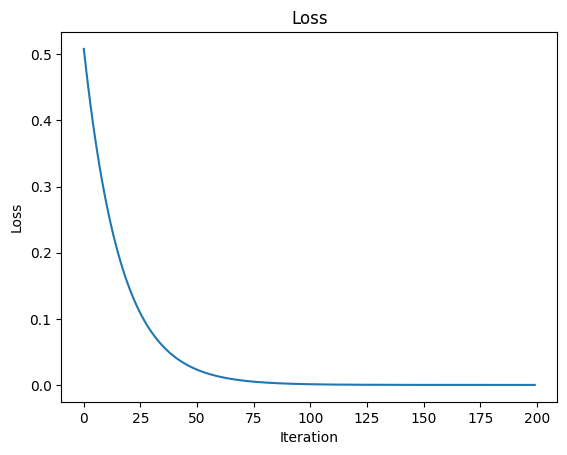

In [101]:
w, b, losses = linear_regression_vectorized(X_train, y_train)

plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss")
plt.show()

In [102]:
y_pred = predict(X_test, w, b)

rmse = root_mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)
mape = mean_absolute_percentage_error(y_pred, y_test)

y_train_pred = predict(X_train, w, b)
train_accuracy = r2_score(y_train, y_train_pred)
test_accuracy = r2_score(y_test, y_pred)

print("Root Mean Square Error (RMSE):", round(rmse, 4))
print("Mean Absolute Error (MAE):", round(mae , 4) )
print("Training Accuracy (R- squared):", round(train_accuracy, 4))
print("Testing Accuracy (R- squared):", round(test_accuracy, 4))

Root Mean Square Error (RMSE): 0.0293
Mean Absolute Error (MAE): 0.0138
Training Accuracy (R- squared): 0.9989
Testing Accuracy (R- squared): 0.9991


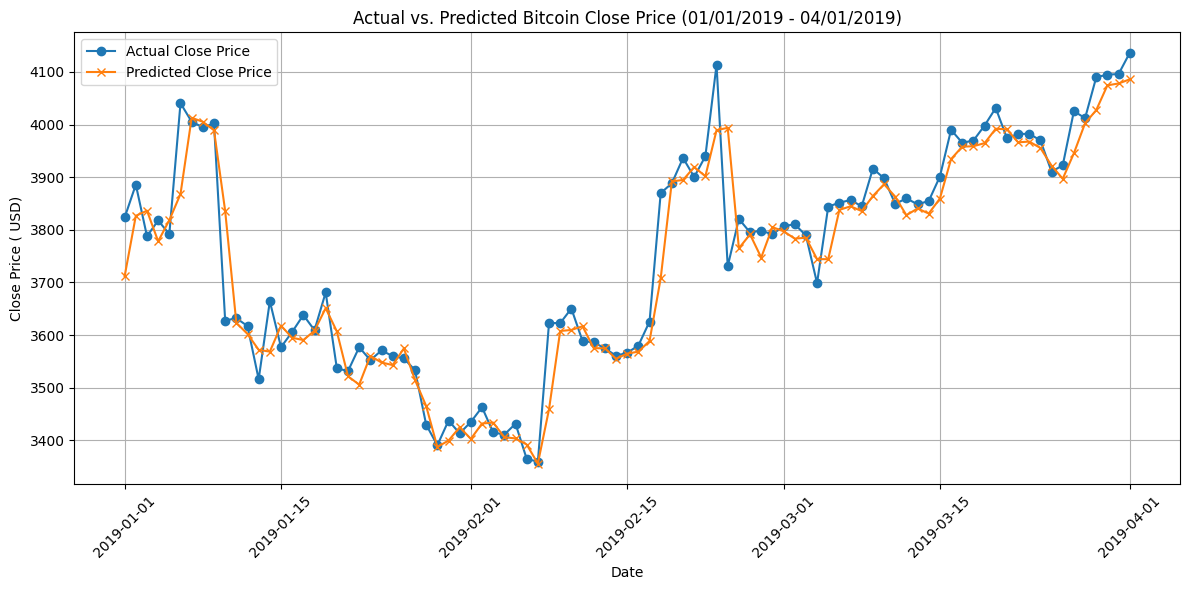

In [103]:
df_2019_q1 = df[(df["date"] >= "2019-01-01") & (df["date"] <= "2019-04-01")]

X_2019_q1 = df_2019_q1[["open", "high", "low"]]
y_2019_q1_actual = df_2019_q1["close"]

y_2019_q1_pred = predict(X_2019_q1, w, b)


plt.figure( figsize =(12 , 6) )
plt.plot(df_2019_q1["date"], y_2019_q1_actual, label="Actual Close Price", marker="o")
plt.plot(df_2019_q1["date"], y_2019_q1_pred, label="Predicted Close Price", marker="x")
plt.title("Actual vs. Predicted Bitcoin Close Price (01/01/2019 - 04/01/2019)")
plt.xlabel("Date")
plt.ylabel("Close Price ( USD)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()